# Spectral wave attenuation for the winter deployment
In this notebook, we derive frequency dependent wave attenuation using data from the winter deployment. During this deployment both buoys were in sea ice the whole time, and the wave activity was high enough to measure (significant wave height \> 0.1 m) during the whole deployment. We derive the attenuation assuming an exponential decay. For each pair of data points, the attenuation coefficient $\alpha$ is computed with
$$
\alpha(f) = \frac{\ln(E_\text{SWIFT20}(f) - E_\text{SWIFT21}(f)}{d}
$$
where $f$ is the frequency, $E$ the power spectral density and $d$ is the projected distance between the buoys in wave direction. For computing $d$, the mean wave direction of the two buoys is used.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

import waves
import attenuation as at

rc('font', size = 14)
plt.rcParams['mathtext.fontset'] = "stix" # Nicer latex labels

In [2]:
swift20_file = "../processed_data/swift20_winter.feather"
swift21_file = "../processed_data/swift21_winter.feather"

frequency_range = [0.05, 0.13] #Hz

### Get wave properties from both buoys:

In [3]:
swift20 = pd.read_feather(swift20_file)
swift21 = pd.read_feather(swift21_file)

In [4]:
tmin = max(swift20.timestamp[0], swift21.timestamp[0])
tmax = min(swift20.timestamp[len(swift20)-1], swift21.timestamp[len(swift21)-1])

swift20_pruned = swift20[(swift20.timestamp >= tmin) & (swift20.timestamp <= tmax)].reset_index()
swift21_pruned = swift21[(swift21.timestamp >= tmin) & (swift21.timestamp <= tmax)].reset_index()

print(f"Used time range: {tmin} - {tmax}")

Used time range: 2019-07-27 02:00:00 - 2019-07-28 09:00:00


### Compute pointwise attenuation
To compute the projected distance between the two buoys, we use the mean wave direction. To check that this is reasonable, we first plot the wave direction measured by the two buoys.

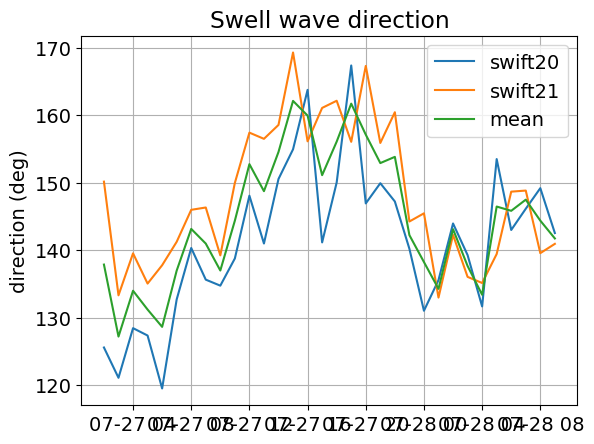

In [5]:
plt.plot(swift20_pruned['timestamp'], swift20_pruned['swell.meandirT'])
plt.plot(swift21_pruned['timestamp'], swift21_pruned['swell.meandirT'])
plt.plot(swift20_pruned['timestamp'], (swift20_pruned['swell.meandirT']+swift21_pruned['swell.meandirT'])/2)
plt.ylabel('direction (deg)')
plt.grid()
plt.title('Swell wave direction')
plt.legend(['swift20', 'swift21', 'mean'])
plt.show()

We are now ready to compute the frequency dependent attenuation

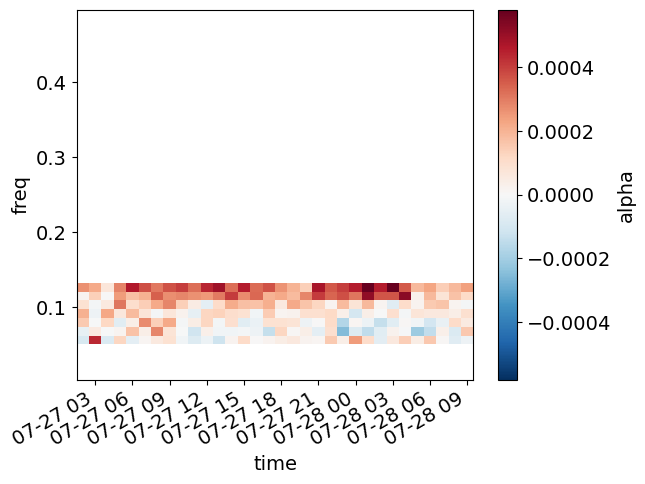

In [6]:
distance = at.distance_in_wave_direction(swift20_pruned, swift21_pruned)
swift20_spectra = waves.get_wavespectra(swift20_pruned)
swift21_spectra = waves.get_wavespectra(swift21_pruned)

ds = at.get_pointwise_attenuation(swift21_spectra, swift20_spectra, frequency_range, distance)
ds.alpha.plot()

### Fit to power law
We now fit the pointwise attenuation to a power law
$$
\alpha(f) = a \cdot f^b
$$
using non-linear least squares. We will do this both with and without constraints on $b$.

In [7]:
# Initial parameter guess
a0 = 1
b0 = 3

fits = {'general':     {'options': {},
                        'plot_kwargs': {'label': r'$af^b$'}},
        'constrained': {'options': {'b_constraint': [2,4]},
                        'plot_kwargs': {'label': r'$af^b$, $2\leq b\leq 4$',
                                        'linestyle': 'dashed'}},
        'cubic':       {'options': {'b': 3},
                        'plot_kwargs': {'label': r'$af^3$',
                                        'linestyle': 'dashed'}},
        'linear':      {'options': {'b':1},
                        'plot_kwargs': {'label': r'$af$',
                                        'linestyle': 'dotted',
                                        'color': 'black'}}
       }

# Fit to power law
for key in fits.keys():
    (a,b,rmse) = at.fit_alpha(ds.alpha, a0, b0, **fits[key]['options'])
    fits[key]['a'] = a
    fits[key]['b'] = b
    fits[key]['rmse'] = rmse

# Print result  
for key in fits.keys():
    print(f"{key}:\t a = {fits[key]['a']:.5f} \t b = {fits[key]['b']:.5f} \t RMSE = {fits[key]['rmse']:.3e}")

general:	 a = 8.41506 	 b = 4.88673 	 RMSE = 1.089e-04
constrained:	 a = 1.27055 	 b = 3.99995 	 RMSE = 1.099e-04
cubic:	 a = 0.14558 	 b = 3.00000 	 RMSE = 1.144e-04
linear:	 a = 0.00149 	 b = 1.00000 	 RMSE = 1.398e-04


## Box-and-whisker plot

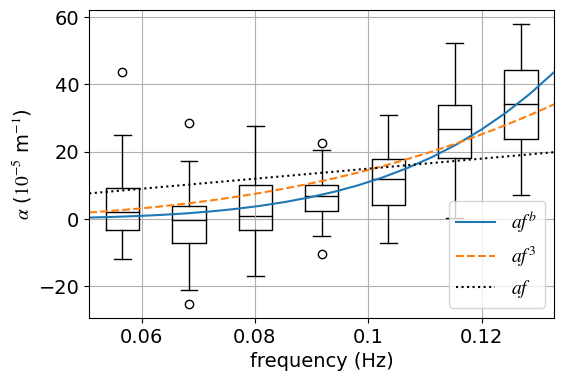

In [8]:
plt.figure(figsize=(6,4))
at.alpha_boxplot(ds.alpha)
for key in fits.keys():
    if key != 'constrained':
        at.plot_fit(fits[key]['a'], fits[key]['b'], **fits[key]['plot_kwargs'])

plt.legend(loc = 'lower right')
plt.grid()
plt.savefig('../figures/winter_atteunation.png', dpi=300, bbox_inches='tight')

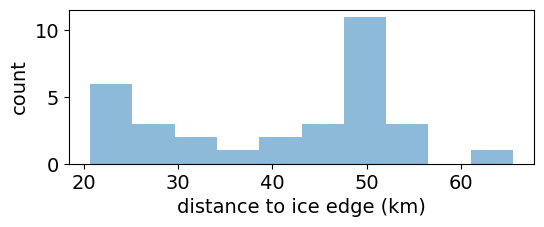

In [9]:
distance_to_edge = (swift20_pruned.dist_wavedir + swift21_pruned.dist_wavedir)/2

plt.figure(figsize=(6,2))
plt.hist(distance_to_edge*1e-3, alpha=0.5)
plt.xlabel('distance to ice edge (km)')
plt.ylabel('count')
plt.savefig('../figures/winter_atteunation_distance.png', dpi=300, bbox_inches='tight')